In [1]:
# %pip install torch
# %pip install -r requirements.txt # uncomment when all required libraries are defined

import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [2]:
def build_metadata(data_dir: str):
    """
    Analyzing and collecting all metadata from the audio files (gender, male or female)
    """
    records = []
    for root, _, files in os.walk(data_dir):
        for fname in files:
            if fname.lower().endswith(".wav"):
                path = os.path.join(root, fname)
                accent = int(fname[0])          # '1'–'5'
                gender = fname[1].lower()       # 'm' or 'f'
                records.append({"path": path, "accent": accent, "gender": gender})
    return pd.DataFrame(records)


class AccentDataset(Dataset):
    """
    PyTorch Dataset for loading, preprocessing, and feature-extracting audio.
    """
    def __init__(
        self,
        metadata_df: pd.DataFrame,
        approach: str = "raw",  # "raw" or "mel"
        max_length: int = 16000 * 5,  # 5 seconds
        sample_rate: int = 16000,
        transform: torch.nn.Module = None,
        target_transform = None
    ):
        self.df = metadata_df.reset_index(drop=True)
        self.approach = approach
        self.max_length = max_length
        self.sample_rate = sample_rate
        self.transform = transform
        self.target_transform = target_transform

        # Silence trimming (VAD)
        self.vad = torchaudio.transforms.Vad(sample_rate=sample_rate)

        # Feature transforms (for 'mel' approach)
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=64,
            n_fft=1024,
            hop_length=512
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(row["path"])

        # Resample if needed
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        # Convert to mono
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Trim leading/trailing silence
        waveform = self.vad(waveform)

        # Pad or truncate to fixed length
        length = waveform.size(1)
        if length < self.max_length:
            pad_amt = self.max_length - length
            waveform = F.pad(waveform, (0, pad_amt))
        else:
            waveform = waveform[:, :self.max_length]

        # Per-sample normalization
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)

        # Optional augmentations
        if self.transform is not None:
            waveform = self.transform(waveform)

        # Feature extraction
        if self.approach == "raw":
            features = waveform  # shape: [1, max_length]
        elif self.approach == "mel":
            mel_spec = self.mel_spectrogram(waveform)
            features = self.db_transform(mel_spec)  # shape: [1, n_mels, time_steps]
        else:
            raise ValueError("approach must be 'raw' or 'mel'")

        label = row["accent"]
        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label



In [19]:
df = build_metadata("/home/mihai/Mihai/Uni stuff/DL/Assingment/Train") # Training dataframe based on accent & gender metadata
raw_ds = AccentDataset(df, approach="raw",  max_length=16000*5)
mel_ds = AccentDataset(df, approach="mel",  max_length=16000*5)

# Dataloaders
batch_size = 32
raw_loader = DataLoader(raw_ds, batch_size=batch_size, shuffle=True, num_workers=4)
mel_loader = DataLoader(mel_ds, batch_size=batch_size, shuffle=True, num_workers=4)

print(df)

print(mel_ds)

                                                   path  accent gender
0     /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       3      m
1     /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       4      m
2     /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       5      m
3     /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       4      f
4     /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       4      m
...                                                 ...     ...    ...
3161  /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       2      f
3162  /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       4      f
3163  /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       4      f
3164  /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       3      f
3165  /home/mihai/Mihai/Uni stuff/DL/Assingment/Trai...       1      f

[3166 rows x 3 columns]


In [ ]:
# Preview a few batches from the raw data
for i, (x, y) in enumerate(raw_loader):
    print(f"Batch {i+1} - Raw data")
    print("Input shape:", x.shape)  # This depends on how your dataset returns input
    print("Target shape or labels:", y)
    print("-" * 40)
    if i == 2:  # Only print first 3 batches
        break

# Preview a few batches from the mel spectrogram data
for i, (x, y) in enumerate(mel_loader):
    print(f"Batch {i+1} - Mel spectrogram data")
    print("Input shape:", x.shape)
    print("Target shape or labels:", y)
    print("-" * 40)
    if i == 2:
        break


Batch 1 - Raw data
Input shape: torch.Size([32, 1, 80000])
Target shape or labels: tensor([5, 3, 2, 4, 1, 4, 2, 1, 4, 1, 1, 5, 3, 1, 1, 2, 4, 3, 5, 2, 1, 4, 1, 3,
        5, 5, 2, 2, 5, 5, 2, 1])
----------------------------------------
Batch 2 - Raw data
Input shape: torch.Size([32, 1, 80000])
Target shape or labels: tensor([3, 1, 3, 1, 2, 3, 1, 1, 4, 3, 2, 4, 3, 1, 2, 1, 3, 3, 3, 4, 3, 2, 5, 4,
        3, 3, 4, 4, 1, 2, 5, 1])
----------------------------------------
Batch 3 - Raw data
Input shape: torch.Size([32, 1, 80000])
Target shape or labels: tensor([4, 2, 2, 1, 4, 1, 5, 1, 1, 2, 3, 1, 4, 5, 4, 5, 2, 2, 1, 3, 3, 2, 4, 1,
        2, 5, 5, 3, 4, 3, 2, 2])
----------------------------------------
Batch 1 - Mel spectrogram data
Input shape: torch.Size([32, 1, 64, 157])
Target shape or labels: tensor([3, 4, 3, 2, 2, 3, 4, 5, 4, 3, 1, 4, 2, 3, 2, 1, 4, 1, 4, 3, 4, 2, 5, 5,
        1, 4, 5, 1, 5, 3, 5, 4])
----------------------------------------
Batch 2 - Mel spectrogram data
Input s

<Axes: xlabel='accent'>

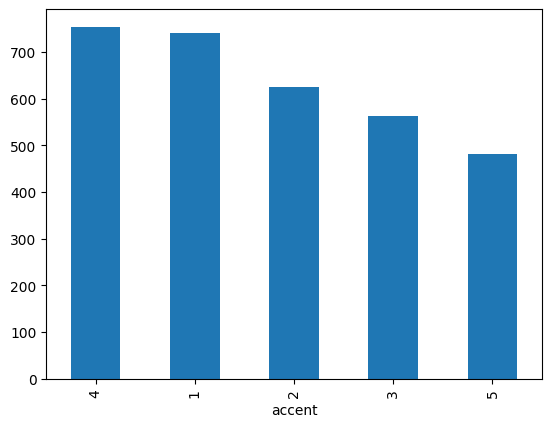

In [18]:
df['accent'].value_counts().plot(kind='bar')  # Distribution by label
#df['gender'].value_counts().plot(kind='bar')  # Distribution by label



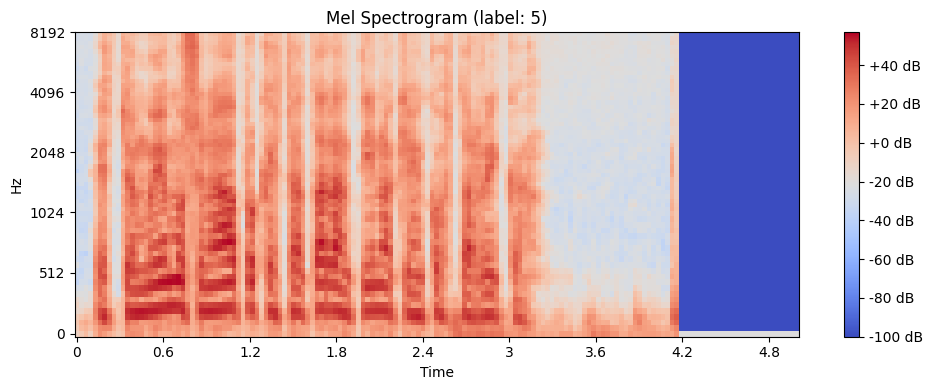

In [12]:
import matplotlib.pyplot as plt
import librosa.display
import torch

# Get a sample from the mel dataset
mel_spec, label = mel_ds[10]

# If it's a PyTorch tensor, convert to NumPy
if isinstance(mel_spec, torch.Tensor):
    mel_spec = mel_spec.numpy()

# If it has an extra channel dimension (e.g., [1, freq, time]), squeeze it
if mel_spec.ndim == 3:
    mel_spec = mel_spec.squeeze(0)

# Plot using librosa
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=16000, hop_length=512, x_axis='time', y_axis='mel')
plt.title(f"Mel Spectrogram (label: {label})")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [5]:
# Test one batch from each loader
raw_batch = next(iter(raw_loader))
mel_batch = next(iter(mel_loader))

print("Raw audio batch shape:", raw_batch[0].shape)  # Should be [batch, time]
print("Mel batch shape:", mel_batch[0].shape)       # Should be [batch, 1, n_mels, time] for CNN

Raw audio batch shape: torch.Size([32, 1, 80000])
Mel batch shape: torch.Size([32, 1, 64, 157])


In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


# Splitting into train/val (80/20) with stratification on accent, so they each appear ~ in the same proportion in train/validation set
val_fraction = 0.2
df_train, df_val = train_test_split(
    df,
    test_size=val_fraction,
    random_state=42,
    stratify=df["accent"]
)
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)



max_length = 16000 * 5  # 5 seconds
batch_size = 32
num_workers = 4

# Raw waveform datasets and loaders
train_ds = AccentDataset(
    metadata_df=df_train,
    approach="raw",       # raw 1D signal
    max_length=max_length,
)
val_ds   = AccentDataset(
    metadata_df=df_val,
    approach="raw",
    max_length=max_length,
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)


